<a href="https://colab.research.google.com/github/Sougotadayglo/DeepLearning_ProjectsUsingBert/blob/DepressionDetetctionUsingContext/SuicideAndDepressionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# remove folder from local files just for debugging purpose
# !rm -rf '/content/uncased_L-12_H-768_A-12'

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 39kB/s 
     |████████████████████████████████| 3.8MB 36.1MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 512kB 36.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=e1ea7837d227ee9c6ca1c5d4657e846cae347e5ed0e6c1c424d7f4d5197ac5c5
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tens

In [1]:
import pandas as pd
import numpy as np
import time
import re
import string
import progressbar
import pickle
from tqdm.notebook import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import plot_confusion_matrix
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [4]:
train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/SuicideAndDepression_Detection.csv')
train.shape

(348124, 2)

In [5]:
train.head()

,text,class
0,Does life actually work for most / non-depress...,depression
1,I found my friend's bodyIt was almost nine yea...,depression
2,Ex Wife Threatening SuicideRecently I left my ...,SuicideWatch
3,Am I weird I don't get affected by compliments...,teenagers
4,Finally 2020 is almost over... So I can never ...,teenagers


In [ ]:

# clean text from noise
def clean_text(text):
    
    # remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # taking sequences of characters with alphanumeric characters separated by other characters
    text = re.sub(r"[-?!&]",' ',text)
    text = re.sub(r'''["#$%()*+,./:;<=>@[\]^_`{|}~]''','',text)
    
    # remove all numeric charracters
    text = re.sub(r'[0-9]','',text)

    text = re.sub(r"\s+"," ", text)

    Apos_dict={"'s":" is","n't":" not","'m":" am","'ll":" will",
           "'d":" would","'ve":" have","'re":" are"}
  
    #replace the contractions
    for key,value in Apos_dict.items():
        if key in text:
            text=text.replace(key,value)

    # convert to lowercase to maintain consistency
    text = text.lower()
       
    return text

text = '''heel!! my9 99 name is daygl? 

    again keep it     rea@l doesn't non-task me th're they've '''
print(clean_text(text))

for i in tqdm(range(348124)):
    try:
        train['text'][i] = clean_text(train['text'][i])
    except:
        print(i)
        train = train.drop(i)
    i+=1

heel my name is daygl again keep it real does not non task me th are they have 


185323



In [ ]:
train.shape

(348123, 2)

In [ ]:

nltk.download('stopwords')
stop = stopwords.words('english')

for i in tqdm(range(348123)):
    try:
        train['text'][i] = ' '.join([word for word in train['text'][i].split() if word not in (stop)])
    except:
        pass

# uncomment this line to do the same task in one line. I just wanted to keep track of the percentage completion.    
# train['text'] = train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


import nltk

lemmatizer = nltk.stem.WordNetLemmatizer()

for i in tqdm(range(348123)):
    try:
        train['text'][i] = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in train['text'][i].split()])
    except:
        pass


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
train.head()

,text,class
0,life actually work non depressed people seem p...,depression
1,found friend bodyit almost nine year ago still...,depression
2,ex wife threaten suiciderecently left wife goo...,SuicideWatch
3,weird get affected compliment come someone kno...,teenagers
4,finally almost never hear bad year ever swear ...,teenagers


In [ ]:

nltk.download('punkt')

i = 0
max_tokens = 0
avg_tokens = 0
data_size = len(train['text'])
bar = progressbar.ProgressBar(maxval=data_size, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

bar.start()
for text in train['text']:
    nltk_tokens = nltk.word_tokenize(text)
    if (len(nltk_tokens) > max_tokens):
        max_tokens = len(nltk_tokens)
    avg_tokens+=(len(nltk_tokens)/data_size)

    i+=1
    bar.update(i)

bar.finish()

print(max_tokens)
print(avg_tokens)

[                                                                        ] N/A%

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[========================================================================] 100%


5850
78.8291580849239


In [ ]:
train = train.rename(columns = {'class' : 'labels'})
train.head()

,text,labels
0,life actually work non depressed people seem p...,depression
1,found friend bodyit almost nine year ago still...,depression
2,ex wife threaten suiciderecently left wife goo...,SuicideWatch
3,weird get affected compliment come someone kno...,teenagers
4,finally almost never hear bad year ever swear ...,teenagers


In [ ]:
train.to_csv('/content/gdrive/MyDrive/Colab Notebooks/preProcessedSuicideAndDepression_Detection.csv', index = False)

In [2]:
train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/preProcessedSuicideAndDepression_Detection.csv')

In [3]:
train.dropna(inplace=True)
train.head()

,text,labels
0,life actually work non depressed people seem p...,depression
1,found friend bodyit almost nine year ago still...,depression
2,ex wife threaten suiciderecently left wife goo...,SuicideWatch
3,weird get affected compliment come someone kno...,teenagers
4,finally almost never hear bad year ever swear ...,teenagers


In [4]:

# split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train.text, train.labels, test_size=0.25, random_state=42)

print('X_train shape:',X_train.shape)
print('X_train shape:',X_val.shape)

X_train shape: (261018,)
X_train shape: (87006,)


In [5]:
X_train

183834    wont get betteri wont get well stop stay im po...
316057             watch futurama thought id date amy leela
28161     suggestion feel worthless overwhelmed like dro...
177238    really really v frustrate time brain decides s...
331116    anyone ever get goosebump shit idk hate make b...
                                ...                        
119918    even sure sayhello everyone sure many people s...
259255        hey wanna know something regret know bout pee
131975    ghost problem againi start feel half scar half...
146914    know girlthis first time make post go nothing ...
121998    school could go train feel well myselfbut woul...
Name: text, Length: 261018, dtype: object

In [6]:
X_val

182258    fuck chemistry chemistry honestly go fuck hole...
188097    b day dont know guy care last birth day teenag...
221083    one read thisi get bad bad try commit suicide ...
309503    found resource make call baby step right httpw...
317025    random text post accident come today day hour ...
                                ...                        
158345    someone depression describe like do want know ...
180634    feel lonely confusedalright really know start ...
90579     im fuckedim lose mind im year old go cant list...
125675    sick work every job shitshow unemployed ca bri...
53591     wise word man help need depressed always expec...
Name: text, Length: 87006, dtype: object

In [ ]:
pip install -U bert-serving-server bert-serving-client

     |████████████████████████████████| 71kB 4.1MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=0d1a6628aebd605596911d5d8199d89515d5efb5bbb6b94260e74b0f113bc916
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil


In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip && unzip uncased_L-12_H-768_A-12.zip

--2021-05-17 08:23:16--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 142.250.98.128, 142.250.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   201MB/s    in 1.9s    

2021-05-17 08:23:18 (201 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [ ]:
!nohup bert-serving-start -model_dir uncased_L-12_H-768_A-12/ -num_worker=2 -max_seq_len 512 > out.file 2>&1 &

In [ ]:
from bert_serving.client import BertClient
# make a connection with the BERT server using it's ip address
bc = BertClient()
# get the embedding for train and val sets
# get the embedding
embedding = bc.encode(['First do it', 'then do it right', 'then do it better'])
# check the shape of embedding, it should be 3x768
print(embedding)
print(embedding.shape)


In [ ]:

X_train_bert = []

for i in tqdm(range(261018)):
    temp = bc.encode(X_train[i:i+1].to_list())
    X_train_bert.append(temp[0])
X_train_bert = np.array(X_train_bert)

import pickle

with open('/content/gdrive/MyDrive/Colab Notebooks/trainSuicideAndDepression_DetectionBERTWordEmbeddings.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(X_train_bert, filehandle)


/usr/local/lib/python3.7/dist-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=512" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


In [ ]:
X_val_bert = []

for i in tqdm(range(87006)):
    temp = bc.encode(X_val[i:i+1].to_list())
    X_val_bert.append(temp[0])
X_val_bert = np.array(X_val_bert)

with open('/content/gdrive/MyDrive/Colab Notebooks/testSuicideAndDepression_DetectionBERTWordEmbeddings.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(X_val_bert, filehandle)

/usr/local/lib/python3.7/dist-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=512" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


In [7]:

with open('/content/gdrive/MyDrive/Colab Notebooks/trainSuicideAndDepression_DetectionBERTWordEmbeddings.data', 'rb') as filehandle:
    # read the data as binary data stream
    X_train_bert = pickle.load(filehandle)

with open('/content/gdrive/MyDrive/Colab Notebooks/testSuicideAndDepression_DetectionBERTWordEmbeddings.data', 'rb') as filehandle:
    # store the data as binary data stream
    X_val_bert = pickle.load(filehandle)

In [8]:
print(X_train_bert)

[[-0.3179774   0.17453584  0.5170291  ... -0.7881806  -0.25709733
   0.00385739]
 [ 0.24498028 -0.06635986  0.12903148 ... -0.47168267  0.05232501
  -0.19207843]
 [-0.3478057   0.49102622  0.81172705 ... -0.8407974  -0.49174997
  -0.18910503]
 ...
 [-0.3070692   0.2546062   0.7424636  ... -0.7569532  -0.30264077
  -0.01356569]
 [-0.5746188   0.08246285  0.7418346  ... -0.5503757  -0.10338228
  -0.35683793]
 [ 0.25714302  0.6005804   0.5426199  ... -0.7847218  -0.38745683
  -0.29998747]]


In [9]:
print(X_val_bert.shape)
print(X_val_bert)

(87006, 768)
[[ 0.585339    1.0363818   0.64045656 ... -0.6225818  -0.13340841
  -0.34627154]
 [-0.12839574  0.22486146  0.87340164 ... -1.2995867  -0.19449522
  -0.633964  ]
 [-0.46718404  0.26355556  0.6910244  ... -1.0066607  -0.41251537
  -0.34015918]
 ...
 [-0.28903404  0.63441694  0.6014907  ... -0.84442043 -0.39032087
  -0.21951003]
 [-0.1503326   0.26507553  0.6809735  ... -0.6676791  -0.24228257
  -0.3163622 ]
 [-0.09856147  0.01743699  0.9631243  ... -0.67891777 -0.41024834
   0.10065776]]


In [10]:
#X_train_bert = bc.encode(X_train[:110].tolist())
#X_val_bert = bc.encode(X_val[:10].tolist())
#X_train_bert

In [11]:
X_train_bert = preprocessing.normalize(X_train_bert)
X_val_bert = preprocessing.normalize(X_val_bert)

In [12]:
scaler_Xtrain_bert = preprocessing.StandardScaler().fit(X_train_bert)
scaler_Xval_bert = preprocessing.StandardScaler().fit(X_val_bert)


#scaler_Xtrain_bert.mean_
#scaler_Xval_bert.mean_

#scaler_Xtrain_bert.scale_
#scaler_Xval_bert.scale_

X_train_bert_scaled = scaler_Xtrain_bert.transform(X_train_bert)
X_val_bert_scaled = scaler_Xval_bert.transform(X_val_bert)

In [13]:
X_train_bert_scaled

array([[-0.84354264, -0.1865741 , -0.21970382, ..., -0.7828243 ,
        -0.14398627,  1.195607  ],
       [ 1.5857632 , -1.3060136 , -2.3423824 , ...,  0.3051776 ,
         1.8832266 , -0.1269326 ],
       [-0.60253716,  0.64486504,  0.26924437, ...,  0.02878136,
        -0.8202379 ,  0.38349113],
       ...,
       [-0.610042  , -0.0087127 ,  0.4226926 , ..., -0.05385228,
        -0.13354443,  1.1091273 ],
       [-1.403291  , -0.6653925 ,  0.2221153 , ...,  0.919883  ,
         0.9623119 , -0.436156  ],
       [ 1.2547529 ,  1.2086799 , -0.64859706, ..., -0.06806116,
        -0.52307975, -0.2123329 ]], dtype=float32)

In [14]:
X_val_bert_scaled

array([[ 2.1988223 ,  2.4995673 , -0.41305   , ...,  0.76582515,
         0.84750724, -0.30187958],
       [ 0.00886925, -0.1454295 ,  0.9263233 , ..., -2.1008368 ,
         0.48203695, -1.7304783 ],
       [-0.8929225 , -0.132767  , -0.3902918 , ..., -0.40468153,
        -0.35984167, -0.18119378],
       ...,
       [-0.504752  ,  1.3003839 , -0.40925017, ..., -0.256922  ,
        -0.5073169 ,  0.1736038 ],
       [-0.04082346, -0.04345081, -0.14194691, ...,  0.5259699 ,
         0.29098913, -0.2153894 ],
       [ 0.12846711, -0.8947375 ,  1.0365644 , ...,  0.54990476,
        -0.48564586,  1.5930755 ]], dtype=float32)

In [ ]:

# LR model
# make dual = True for solver = 'liblinear' 
lrModel = LogisticRegression(dual=False, max_iter=1000, solver='saga')

# train
start = time.time()                                
lrModel.fit(X_train_bert[:210000], y_train[:210000])
end = time.time()

# predict
lrPred = lrModel.predict(X_val_bert)

In [ ]:
print(accuracy_score(y_val, lrPred))
print(end-start)

In [ ]:
print(f1_score(y_val, lrPred, average='micro'))

0.7820610072868538


In [18]:
np.set_printoptions(precision=2)
class_names = ['depression', 'SuicideWatch','teenagers']

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

Confusion matrix, without normalization
[[20442  6822  1533]
 [ 5975 21575  1543]
 [ 1544  1545 26027]]
Normalized confusion matrix
[[0.71 0.24 0.05]
 [0.21 0.74 0.05]
 [0.05 0.05 0.89]]


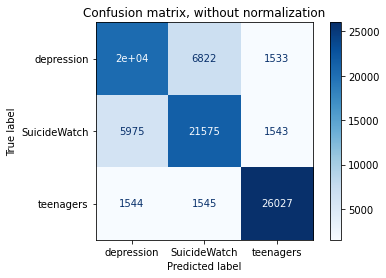

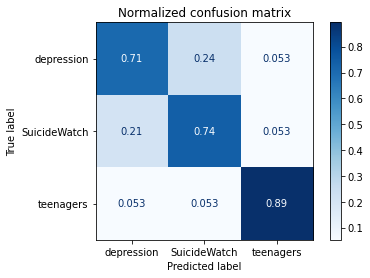

In [ ]:
for title, normalize in titles_options:

    disp = plot_confusion_matrix(lrMmodel, X_val_bert_scaled, y_val,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
# SVM model
svmModel = svm.SVC(kernel = 'linear', C=10, cache_size=700)

#train
start = time.time()
svmModel.fit(X_train_bert_scaled[:50000], y_train[:50000]);
end = time.time()

#predict
svmPred = svmModel.predict(X_val_bert_scaled)

In [ ]:
print(accuracy_score(y_val, svmPred))
print(end-start)

In [ ]:
print(f1_score(y_val, lrPred, average='micro'))

In [ ]:
for title, normalize in titles_options:

    disp = plot_confusion_matrix(svmMmodel, X_val_bert_scaled, y_val,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
nbModel = GaussianNB()

start = time.time()
nbModel.fit(X_train_bert_scaled, y_train)
end = time.time()

nbPred = nbModel.predict(X_val_bert_scaled)

In [ ]:
print(accuracy_score(y_val, nbPred))
print(end-start)

0.6205778911799186
3.8255434036254883


Confusion matrix, without normalization
[[ 9559 13637  5601]
 [ 3902 21190  4001]
 [ 2884  2987 23245]]
Normalized confusion matrix
[[0.33 0.47 0.19]
 [0.13 0.73 0.14]
 [0.1  0.1  0.8 ]]


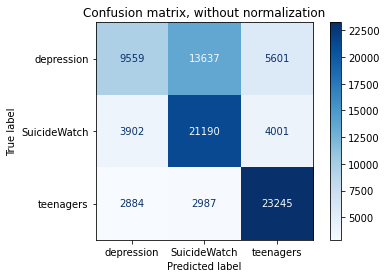

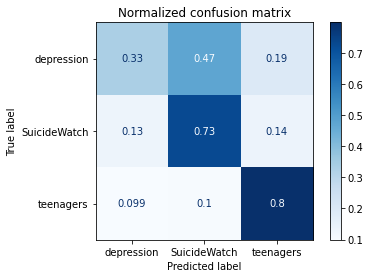

In [ ]:
for title, normalize in titles_options:

    disp = plot_confusion_matrix(nbModel, X_val_bert_scaled, y_val,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
knnModel = KNeighborsClassifier(n_neighbors = 55, p=2, leaf_size= 100)

start = time.time()
knnModel.fit(X_train_bert_scaled, y_train)
end = time.time()

knnPred = knnModel.predict(X_val_bert_scaled[:20000])

In [ ]:
print(accuracy_score(y_val[:20000], knnPred))
print(end-start)

In [ ]:
for title, normalize in titles_options:

    disp = plot_confusion_matrix(knnModel, X_val_bert_scaled, y_val,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
knnModel = KNeighborsClassifier(n_neighbors = 55, p=2, leaf_size= 100)

start = time.time()
knnModel.fit(X_train_bert_scaled, y_train)
end = time.time()

knnPred = knnModel.predict(X_val_bert_scaled)

In [ ]:
print(accuracy_score(y_val, knnPred))
print(end-start)

In [ ]:
for title, normalize in titles_options:

    disp = plot_confusion_matrix(knnModel, X_val_bert_scaled, y_val,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [15]:
from sklearn.svm import LinearSVC

linearSvmModel = LinearSVC(dual=False, max_iter=2000)

start = time.time()
linearSvmModel.fit(X_train_bert,y_train)
end = time.time()

linearSvmPred = linearSvmModel.predict(X_val_bert)

In [16]:
print(accuracy_score(y_val, linearSvmPred))
print(end-start)

0.7789347861067053
335.70783376693726


Confusion matrix, without normalization
[[20017  7059  1721]
 [ 5793 21542  1758]
 [ 1431  1472 26213]]
Normalized confusion matrix
[[0.7  0.25 0.06]
 [0.2  0.74 0.06]
 [0.05 0.05 0.9 ]]


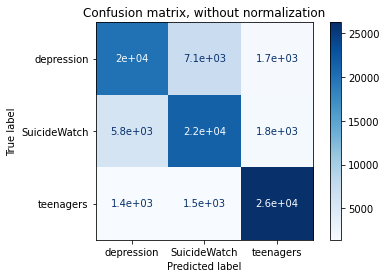

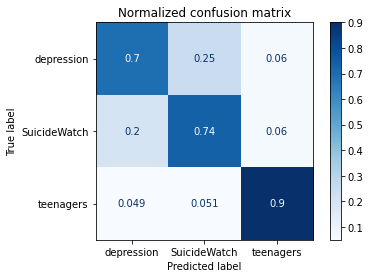

In [19]:
for title, normalize in titles_options:

    disp = plot_confusion_matrix(linearSvmModel, X_val_bert, y_val,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
print(f1_score(y_val, linearSvmPred, average='micro'))